In [77]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset, Subset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [78]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [79]:
# Define transformations
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5,.5,.5],[.5,.5,.5])
])

# download the CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
devtest = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


print(trainset)

print(trainset.classes)

print(devtest)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [80]:
# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader = DataLoader(devset,batch_size=batchsize)
test_loader  = DataLoader(testset,batch_size=len(testset))

# check size (should be images X channels X width X height
print( train_loader.dataset )
print( trainset.classes )

print( test_loader.dataset )
print( devtest.classes )

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


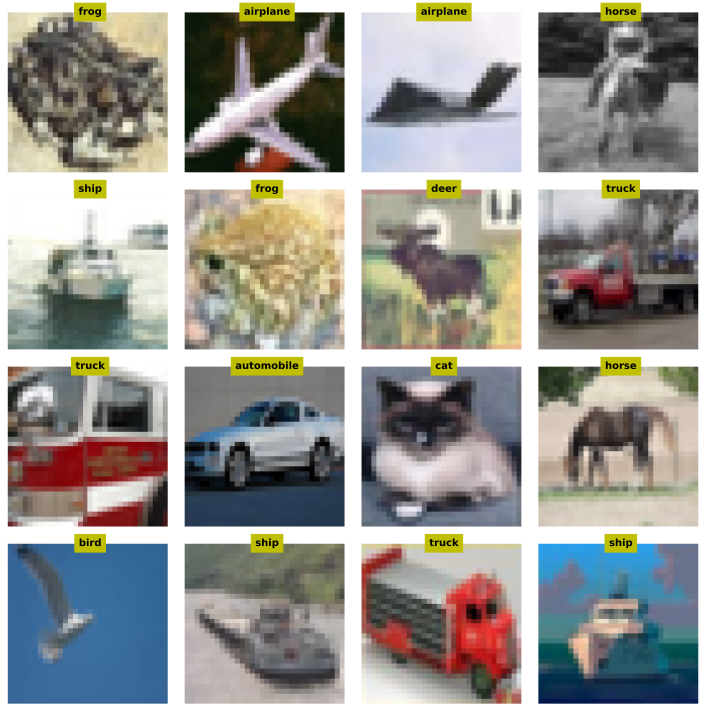

In [81]:
# inspect a few random images

X,y = next(iter(train_loader))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  origPic = X.data[i].numpy().transpose((1,2,0))
  origPic = origPic/2 + .5 # undo normalization
  
  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(origPic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [82]:
# create a class for the model
def createTheNet():

  class cifar10AE(nn.Module):
    def __init__(self):
      super().__init__()
      
       # Encoder
      self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),  # Input: 3 channels (RGB), Output: 8 channels
        nn.LeakyReLU(),
        nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # Output: 16 channels, Downsample
        nn.LeakyReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: 32 channels, Downsample
        nn.LeakyReLU(),
      )

      # Decoder (symmetrical to encoder with transposed convolutions)
      self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upsample, Output: 16 channels
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Upsample, Output: 8 channels
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),  # Output: 3 channels (reconstructed image)
        nn.LeakyReLU()
      )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  # create the model instance
  net = cifar10AE()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [83]:
# test the model with one batch
net,lossfun,optimizer = createTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 3, 32, 32])
 
Loss:
tensor(0.2887, grad_fn=<MseLossBackward0>)


In [84]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 20
  
  # create a new model
  net,lossfun,optimizer = createTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
   
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())

    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    ### test performance
    
    batchLoss = []  

    net.eval() 
    
    for X,y in dev_loader:

      # push data to GPU
      X = X.to(device)     

      with torch.no_grad(): # deactivates autograd
        yHat = net(X)
        loss = lossfun(yHat,X)
        
      # get loss and error rate from the test batch
      batchLoss.append(loss.item())
      
    devLoss[epochi] = np.mean(batchLoss)   

  # end epochs

  # function output
  return trainLoss,devLoss,net

In [85]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,devLoss,net = function2trainTheModel()

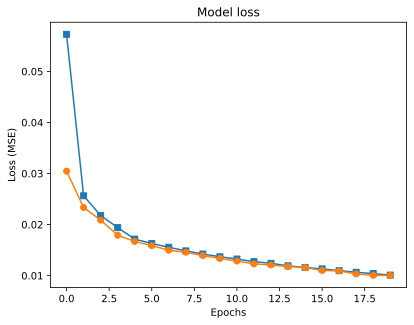

In [86]:

plt.plot(trainLoss,'s-',label='Train')
plt.plot(devLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


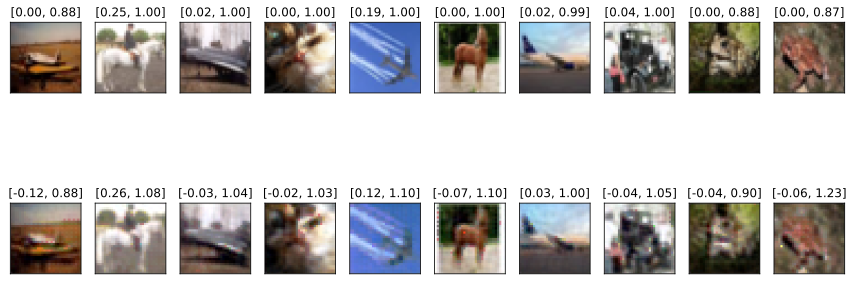

In [91]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(dev_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

X = X.cpu()
yHat = yHat.cpu()

# visualize some images
fig,axs = plt.subplots(2,10,figsize=(15,6))

random_rows = np.random.choice(X.shape[0], size=10, replace=False)

for i in range(10):
  
  # extract that image (need to transpose it back to 32x32x3)
  origPic = X.data[random_rows[i]].numpy().transpose((1,2,0))
  origPic = origPic/2 + .5 # undo normalization

  aePic = yHat.data[random_rows[i]].numpy().transpose((1,2,0))
  aePic = aePic/2 + .5 # undo normalization
  
  # visualize
  axs[0,i].imshow(origPic)
  axs[0,i].set_title(f"[{np.min(origPic):.2f}, {np.max(origPic):.2f}]")
  axs[0,i].set_xticks([])
  axs[0,i].set_yticks([])

  axs[1,i].imshow(aePic)
  axs[1,i].set_title(f"[{np.min(aePic):.2f}, {np.max(aePic):.2f}]")
  axs[1,i].set_xticks([])
  axs[1,i].set_yticks([])

plt.show()